In [0]:
# load file paths and constants

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


# file paths
PATH = "/content/drive/My Drive/"
file_path = "/content/drive/My Drive/book_cover_data/title30/title30cat_2.zip"
csv_path = "/content/drive/My Drive/book_cover_data/title30/book30short.csv"
cover_path = "/content/224x224/"

# constants
val_ratio = 0.1
test_ratio = 0.1
BUFFER_SIZE = 1000
BATCH_SIZE = 32
steps_train = (57000*0.8) // BATCH_SIZE
steps_val = (57000*0.1) // BATCH_SIZE
steps_test = (57000*0.1) // BATCH_SIZE
IMG_DIM = (224, 224, 3)
outdim_size = 30
vocab_size = 17997

# tfrecord file name for train, test and val
tfrecord_path = ["train_data.tfrecord", "val_data.tfrecord", "test_data.tfrecord"]

# unzip files
def unzip_data(file_path):
  from zipfile import ZipFile
  with ZipFile(file_path, "r") as zip:
    zip.extractall()
    return "Data has been extracted"

unzip_data(file_path)

2.2.0


In [0]:
# load helper function for tensorflow data pipleline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# helper functions for writing tfrecord data
def load_csv():
    df = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')
    # keep_cat = [ 2, 29, 22,  9, 16, 14,  6, 28,  7,  3]
    # df = df[(df['cat_id'].isin(keep_cat))].reset_index()
    # split the data into train, validation and test
    train_data, val_data = train_test_split(df, test_size=(test_ratio+val_ratio), random_state=21)
    val_data, test_data = train_test_split(val_data, test_size=test_ratio/(test_ratio+val_ratio), random_state=21)

    return train_data, val_data, test_data


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# functions for process texts
def get_token(texts, word_freq=5):
  words = texts.str.split(expand=True).stack().value_counts()
  words = pd.DataFrame(words, columns=["freq"])
  vocab_size = len(words[words.freq > word_freq])
  token = Tokenizer(num_words=vocab_size)
  token.fit_on_texts(texts)
  return token, vocab_size

def get_text_sequence(text, token, max_len=100):
  sequences = token.texts_to_sequences([text])
  return pad_sequences(sequences,maxlen=max_len).reshape(-1)

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def make_example(image_string, text_sequence, label, keras_hub=False):
    if keras_hub:
      text_seq = _bytes_feature(text_sequence.encode())
    else:
      text_seq = tf.train.Feature(int64_list=tf.train.Int64List(value=text_sequence))

    feature = {
        'image_string': _bytes_feature(image_string),
        'text_sequence': text_seq,
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(data, token, tfrecord_path, keras_hub=False):
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for _,row in data.iterrows():
            img_file = cover_path+row["file"]
            text_sequence = row["text"] if keras_hub else get_text_sequence(row["text"], token)
            label = row["cat_id"]
            image_string = open(img_file, 'rb').read()
            example = make_example(image_string, text_sequence, label, keras_hub)  
            writer.write(example.SerializeToString()) 

# healper functions for reading tfrecord data 
feature_description = {
    'image_string': tf.io.FixedLenFeature([], tf.string),
    'text_sequence': tf.io.FixedLenFeature([100], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

feature_description_hub = {
    'image_string': tf.io.FixedLenFeature([], tf.string),
    'text_sequence': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def parse_image(image):
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [IMG_DIM[0], IMG_DIM[1]])
  return image


def parser(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image_string = parsed_features['image_string']
    image_string = parse_image(image_string)
    text_sequence = parsed_features['text_sequence']
    label = parsed_features['label']
    return (image_string, text_sequence), label

def parser_hub(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description_hub)
    image_string = parsed_features['image_string']
    image_string = parse_image(image_string)
    text_sequence = parsed_features['text_sequence']
    label = parsed_features['label']
    return (image_string, text_sequence), label

def get_dataset(tfrecord_path, keras_hub=False, batch_size=BATCH_SIZE):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    if keras_hub:
        dataset = dataset.map(parser_hub, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    #dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

    
def load_cat(newdata, tfrecord_path = "new.tfrecord", keras_hub=False):
    data = load_csv()
    token, _ = get_token(data[0].text)
    
    dataset = []
    for i in range(outdim_size):
        tfrecord_path = "test_cat"+str(i)+".tfrecord"
        write_tfrecord(newdata[i], token, tfrecord_path, keras_hub)
        dataset.append(get_dataset(tfrecord_path, keras_hub))

    return dataset

def load_data(first_time=True, keras_hub=False):
    if first_time:
        data = load_csv()
        token, _ = get_token(data[0].text)
        for i in range(3):
           write_tfrecord(data[i], token, tfrecord_path[i], keras_hub)

    # load the dataset    
    dataset = []   
    for i in range(3):
        data = get_dataset(tfrecord_path[i], keras_hub)
        dataset.append(data)
    return dataset


In [0]:
train_data, val_data, test_data = load_data(True, True)

In [0]:
# TRAIN MODEL
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt


def train_model(model, epoch_num):
  
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)
    checkpointer = ModelCheckpoint(filepath="temp_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
  
    history = model.fit(train_data.repeat(),
                        steps_per_epoch = steps_train,
                        epochs = epoch_num,
                        validation_data= val_data.repeat(),
                        validation_steps = steps_val,
                        use_multiprocessing=True,
                        callbacks=[checkpointer, earlystop])


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    model.load_weights("temp_weights.h5")

    results = model.evaluate(test_data, use_multiprocessing=True, verbose=1)

    print('loss on test data: ', results)

    results = model.evaluate(val_data, use_multiprocessing=True, verbose=1)

    print('loss on validation data: ', results)
    return model

**General Concatenate**

In [0]:
# TRAIN MODEL
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt


# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


def train_model(model, epoch_num):
    temp_weight_path = "temp_weightsCONC.h5"
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=1)
    checkpointer = ModelCheckpoint(filepath=temp_weight_path, verbose=1, save_best_only=True, save_weights_only=True)
  
    history = model.fit(train_data.repeat(),
                        steps_per_epoch = steps_train,
                        epochs = epoch_num,
                        validation_data= val_data.repeat(),
                        validation_steps = steps_val,
                        use_multiprocessing=True,
                        callbacks=[checkpointer, earlystop])


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    model.load_weights(temp_weight_path)

    results = model.evaluate(test_data, use_multiprocessing=True, verbose=1)

    print('loss on test data: ', results)

    results = model.evaluate(val_data, use_multiprocessing=True, verbose=1)

    print('loss on validation data: ', results)
    return model

TF HUB Concatenation


In [0]:
# create model
from tensorflow.keras import layers, models, optimizers, losses, regularizers, metrics, applications
import tensorflow_hub as hub

# constant for model compile
loss_fn = losses.sparse_categorical_crossentropy
optimizer_fn = optimizers.Adam()
metric_ls = ["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(3)]

def create_hubmodel_conc(img_base, text_base):
    """
    builds the whole model
    the structure of each sub-network is defined in build_mlp_net,
    and it can easily get substituted with a more efficient and powerful network like CNN
    """
    view1_model = build_hubnet_image(img_base)
    view2_model = build_hubnet_text(text_base)
    
    model_concat = layers.concatenate([view1_model.output, view2_model.output], axis=-1)
    out = layers.Dense(outdim_size, activation='softmax')(model_concat)
    model = models.Model(inputs=[view1_model.input, view2_model.input], outputs=out)
    
    model.compile(loss=loss_fn, optimizer=optimizer_fn, metrics=metric_ls)

    return model


def build_hubnet_image(img_base):
    model = models.Sequential()
    model.add(layers.Input(IMG_DIM))
    model.add(img_base)
    model.add(layers.Dense(outdim_size, activation="relu"))
    return model

def build_hubnet_text(text_base):
    model = models.Sequential()
    model.add(text_base)
    model.add(layers.Dense(outdim_size, activation="relu"))
    return model



In [0]:
img_base = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
text_base = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
img_base = hub.KerasLayer(img_base, input_shape=[])
text_base = hub.KerasLayer(text_base, input_shape=[], dtype=tf.string)

In [0]:
model = create_hubmodel_conc(img_base, text_base)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
keras_layer_1_input (InputLayer [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 2048)         23561152    input_1[0][0]                    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      (None, 512)          147354880   keras_layer_1_input[0][0]        
______________________________________________________________________________________________

In [0]:
!cp "/content/drive/My Drive/Final/BC Weighted/concat_weights.h5" "concat.h5" 
model.load_weights("concat.h5")

Epoch 1/25
1425/1425 [==============================] - ETA: 0s - loss: 2.1712 - accuracy: 0.4145 - sparse_top_k_categorical_accuracy: 0.6120
Epoch 00001: val_loss improved from inf to 1.74642, saving model to temp_weightsCONC.h5
1425/1425 [==============================] - 173s 122ms/step - loss: 2.1712 - accuracy: 0.4145 - sparse_top_k_categorical_accuracy: 0.6120 - val_loss: 1.7464 - val_accuracy: 0.5097 - val_sparse_top_k_categorical_accuracy: 0.7307
Epoch 2/25
1425/1425 [==============================] - ETA: 0s - loss: 1.6511 - accuracy: 0.5354 - sparse_top_k_categorical_accuracy: 0.7536
Epoch 00002: val_loss improved from 1.74642 to 1.62312, saving model to temp_weightsCONC.h5
1425/1425 [==============================] - 168s 118ms/step - loss: 1.6511 - accuracy: 0.5354 - sparse_top_k_categorical_accuracy: 0.7536 - val_loss: 1.6231 - val_accuracy: 0.5425 - val_sparse_top_k_categorical_accuracy: 0.7611
Epoch 3/25
1425/1425 [==============================] - ETA: 0s - loss: 1.5452

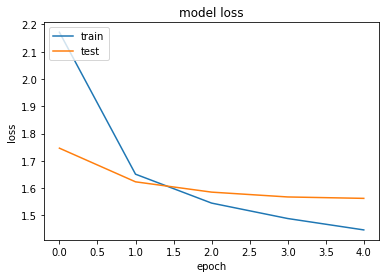

178/178 [==============================] - 18s 100ms/step - loss: 1.5511 - accuracy: 0.5599 - sparse_top_k_categorical_accuracy: 0.7820
loss on test data:  [1.5510530471801758, 0.5598665475845337, 0.7819522619247437]
178/178 [==============================] - 18s 100ms/step - loss: 1.5607 - accuracy: 0.5586 - sparse_top_k_categorical_accuracy: 0.7737
loss on validation data:  [1.5606544017791748, 0.5586376190185547, 0.7737008333206177]


In [0]:
model = train_model(model, 25)

**Visualization**

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
tedf = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')
cat_tup = tedf.groupby(["cat_id", "cat"]).count().index.values
cat_dict=dict() 
for cat_id,cat in cat_tup: 
    cat_dict[cat_id] = cat
print(cat_dict)

{0: 'Arts & Photography', 1: 'Biographies & Memoirs', 2: 'Business & Money', 3: 'Calendars', 4: "Children's Books", 5: 'Comics & Graphic Novels', 6: 'Computers & Technology', 7: 'Cookbooks, Food & Wine', 8: 'Crafts, Hobbies & Home', 9: 'Christian Books & Bibles', 10: 'Engineering & Transportation', 11: 'Health, Fitness & Dieting', 12: 'History', 13: 'Humor & Entertainment', 14: 'Law', 15: 'Literature & Fiction', 16: 'Medical Books', 17: 'Mystery, Thriller & Suspense', 18: 'Parenting & Relationships', 19: 'Politics & Social Sciences', 20: 'Reference', 21: 'Religion & Spirituality', 22: 'Romance', 23: 'Science & Math', 24: 'Science Fiction & Fantasy', 25: 'Self-Help', 26: 'Sports & Outdoors', 27: 'Teen & Young Adult', 28: 'Test Preparation', 29: 'Travel'}


In [0]:
# confution matrix creation 

_,_,df = load_csv() # load train data 
df = tedf
print("...df loaded")
BATCH_SIZE = 32
results = []
newdata = []

# seperate data based on category
for i in range(outdim_size):
  newdata.append(df[df.cat_id==i])

# write tfrecord file and load dataset outdim_siz number of dataset
dataset = load_cat(newdata, keras_hub=True)
print("...dataset loaded")

...df loaded
...dataset loaded


In [0]:
# count many category in each tfrecord file
cat_sample_size = df.groupby(["cat", "cat_id"]).count().file

from collections import Counter

# each iteration the below code will count the predic and apend in the prediction list
pred_count = []
# list of dataframe that contains the prediction layer for each category
prob_df_list = []
for i in range(outdim_size):
  steps = cat_sample_size[i] // BATCH_SIZE
  prob_y = model.predict(dataset[i].repeat(), steps=steps)
  pred_y = tf.argmax(prob_y, 1)
  pred_count.append(Counter(pred_y.numpy()))

  feat_cols = ['f'+str(k) for k in range(prob_y.shape[1])]
  prob_df = pd.DataFrame(prob_y,columns=feat_cols)
  prob_df["genre"] = [cat_dict[i] for k in range(prob_y.shape[0])]
  prob_df_list.append(prob_df)

# put all the predict into confusion matrix where row is truth value
conf_mat = pd.DataFrame(pred_count, columns=range(outdim_size))
conf_mat.fillna(0, inplace=True)

# prediction layer with true category
prob_df = pd.concat(prob_df_list, ignore_index=True, sort=False)

In [0]:
df = prob_df.copy()

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.06785113 0.06479148 0.0611852 ]


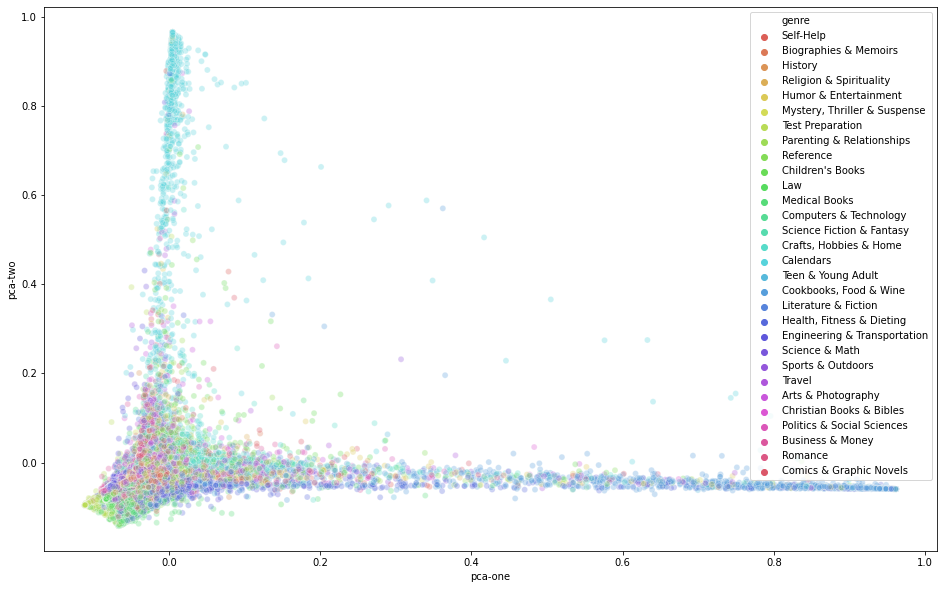

In [0]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="genre",
    palette=sns.color_palette("hls", outdim_size),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

In [0]:
N = 15000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.0707921  0.06771003 0.06215166]


In [0]:
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.050s...
[t-SNE] Computed neighbors for 15000 samples in 8.362s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sa

In [0]:
import matplotlib.markers as markers
all_shapes=markers.MarkerStyle.markers.keys()
all_shapes
mark30 = list(all_shapes)[0:30]

In [0]:
sns.set_style("axis")
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': 'white',
 'axes.facecolor': '#EAEAF2',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': 'white',
 'grid.linestyle': '-',
 'image.cmap': 'rocket',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': '.15',
 'xtick.bottom': False,
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False}

<Figure size 2304x2304 with 0 Axes>

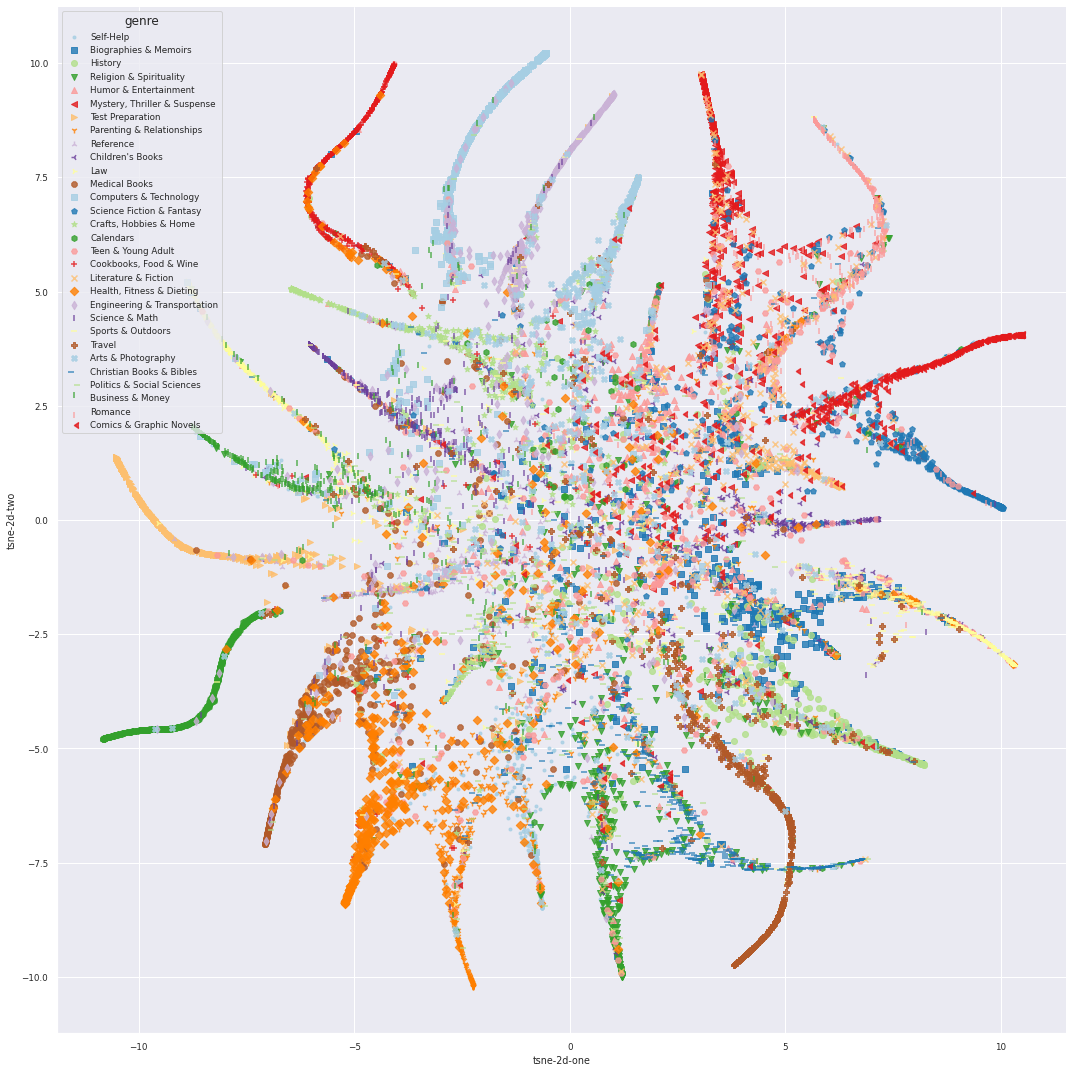

In [0]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(32,32))
sns.set(font_scale=.8)
ax = sns.lmplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="genre",
    palette=sns.color_palette("Paired", 30),
    data=df_subset,
    legend="full",
    markers=mark30,
    scatter=True, fit_reg=False, legend_out=False, height=15
)

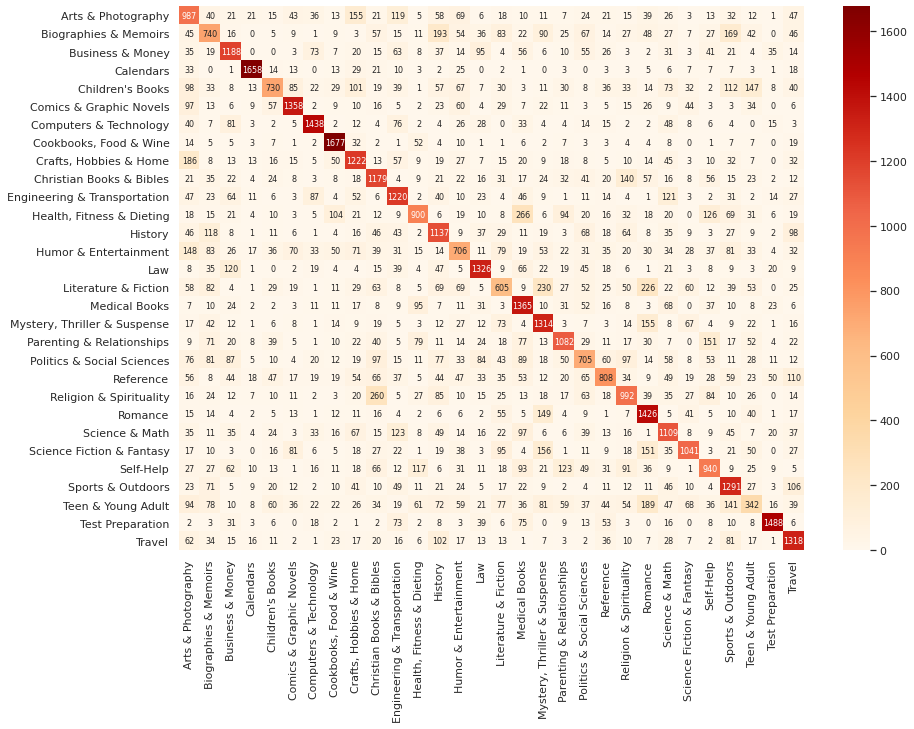

In [0]:
df_cm = pd.DataFrame(conf_mat.values.astype(int), cat_dict.values(), cat_dict.values())
plt.figure(figsize=(14,10))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True,fmt='d', annot_kws={"size": 8}, cmap="OrRd") # font size

plt.show()

In [0]:
for i in range(outdim_size):
  acc = conf_mat.values[i,i]/sum(conf_mat.loc[i,:])
  print(cat_dict[i]," (",str(i), "): ",  str(acc*100), " %")

Arts & Photography  ( 0 ):  52.277542372881356  %
Biographies & Memoirs  ( 1 ):  39.19491525423729  %
Business & Money  ( 2 ):  62.92372881355932  %
Calendars  ( 3 ):  87.8177966101695  %
Children's Books  ( 4 ):  38.66525423728814  %
Comics & Graphic Novels  ( 5 ):  71.92796610169492  %
Computers & Technology  ( 6 ):  76.16525423728814  %
Cookbooks, Food & Wine  ( 7 ):  88.82415254237289  %
Crafts, Hobbies & Home  ( 8 ):  64.72457627118644  %
Christian Books & Bibles  ( 9 ):  62.44703389830508  %
Engineering & Transportation  ( 10 ):  64.61864406779661  %
Health, Fitness & Dieting  ( 11 ):  47.66949152542373  %
History  ( 12 ):  60.222457627118644  %
Humor & Entertainment  ( 13 ):  37.39406779661017  %
Law  ( 14 ):  70.23305084745762  %
Literature & Fiction  ( 15 ):  32.04449152542373  %
Medical Books  ( 16 ):  72.29872881355932  %
Mystery, Thriller & Suspense  ( 17 ):  69.59745762711864  %
Parenting & Relationships  ( 18 ):  57.309322033898304  %
Politics & Social Sciences  ( 19 ):  

Prediction

In [0]:
from IPython.display import Image, display

In [0]:
df = tedf
def preprocess_data(curr_df=df, singlefile = "single.tfrecord"):
  write_tfrecord(curr_df, "token", singlefile, True)
  return get_dataset(singlefile, True, 1)

def get_prediction(id, curr_df=df):  
  curr_df = curr_df[curr_df.index == str(id)]
  data = preprocess_data(curr_df)
  pred = model.predict(data, steps=1)
  pred = np.argmax(pred)
  show_image(curr_df.file[0])
  print("predicted: ", cat_dict[pred])
  print("orignial: ", curr_df.cat[0])
  print(id)
  print()

def show_image(filename):
  display(Image(cover_path+filename))

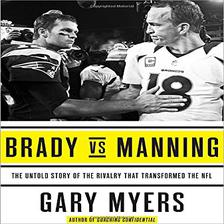

predicted:  Biographies & Memoirs
orignial:  Biographies & Memoirs
804139377



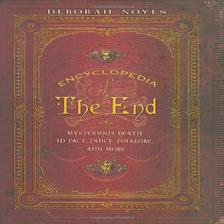

predicted:  Politics & Social Sciences
orignial:  Teen & Young Adult
061882362X



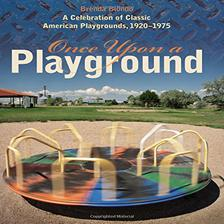

predicted:  Literature & Fiction
orignial:  Humor & Entertainment
1611685125



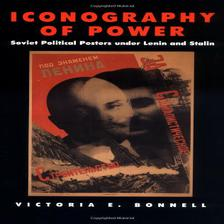

predicted:  Arts & Photography
orignial:  Crafts, Hobbies & Home
520221532



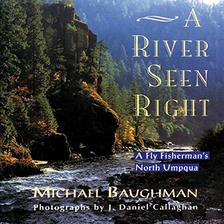

predicted:  Travel
orignial:  Humor & Entertainment
1558214216



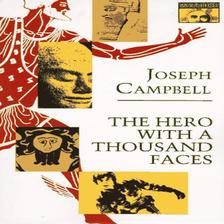

predicted:  Literature & Fiction
orignial:  Literature & Fiction
691017840



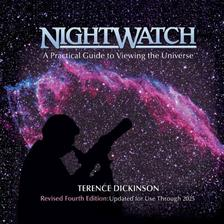

predicted:  Science & Math
orignial:  Science & Math
155407147X



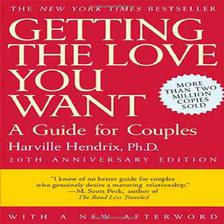

predicted:  Parenting & Relationships
orignial:  Parenting & Relationships
805087001



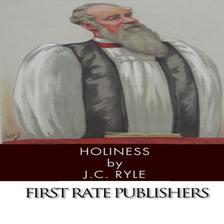

predicted:  Christian Books & Bibles
orignial:  Christian Books & Bibles
1494300710



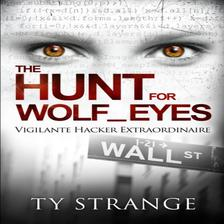

predicted:  Mystery, Thriller & Suspense
orignial:  Mystery, Thriller & Suspense
990539202



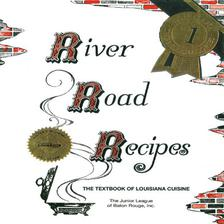

predicted:  Cookbooks, Food & Wine
orignial:  Cookbooks, Food & Wine
961302682



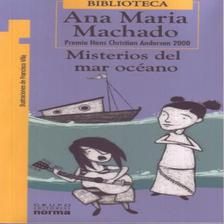

predicted:  Children's Books
orignial:  Teen & Young Adult
9580491143



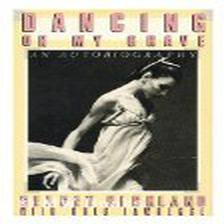

predicted:  Arts & Photography
orignial:  Humor & Entertainment
385199643



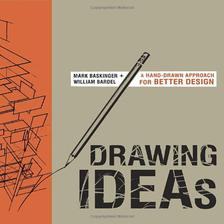

predicted:  Arts & Photography
orignial:  Arts & Photography
385344627



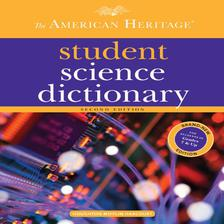

predicted:  Reference
orignial:  Teen & Young Adult
547857314



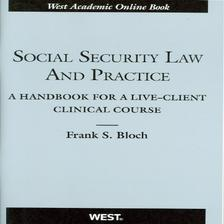

predicted:  Medical Books
orignial:  Law
314265023



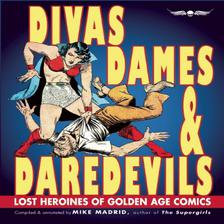

predicted:  Comics & Graphic Novels
orignial:  Comics & Graphic Novels
1935259237



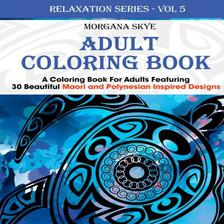

predicted:  Arts & Photography
orignial:  Arts & Photography
1517782503



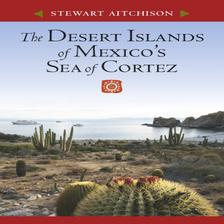

predicted:  Travel
orignial:  Science & Math
816527741



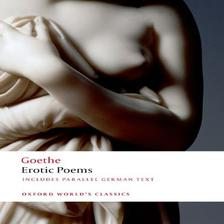

predicted:  Literature & Fiction
orignial:  Romance
199549729



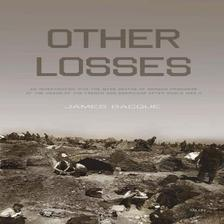

predicted:  History
orignial:  History
889226652



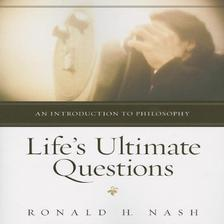

predicted:  Politics & Social Sciences
orignial:  Politics & Social Sciences
310514924



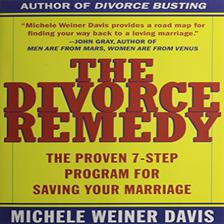

predicted:  Parenting & Relationships
orignial:  Parenting & Relationships
684873257



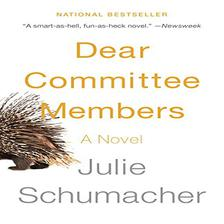

predicted:  Mystery, Thriller & Suspense
orignial:  Humor & Entertainment
345807332



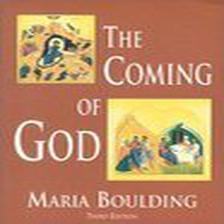

predicted:  Christian Books & Bibles
orignial:  Religion & Spirituality
281048169



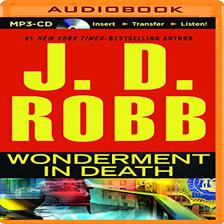

predicted:  Mystery, Thriller & Suspense
orignial:  Romance
1501223771



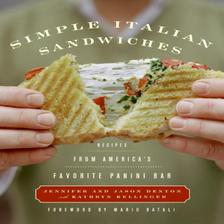

predicted:  Cookbooks, Food & Wine
orignial:  Cookbooks, Food & Wine
006059974X



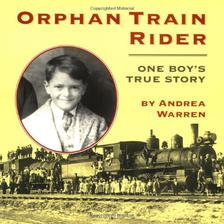

predicted:  Children's Books
orignial:  Children's Books
395913624



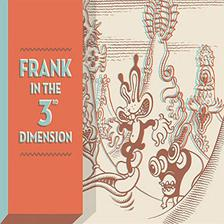

predicted:  Arts & Photography
orignial:  Comics & Graphic Novels
1606998994



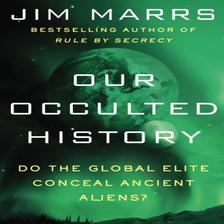

predicted:  Science & Math
orignial:  Science & Math
62130323



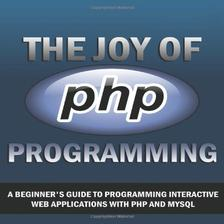

predicted:  Computers & Technology
orignial:  Computers & Technology
1494267357



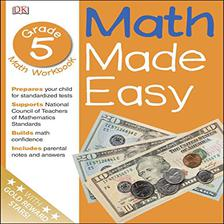

predicted:  Test Preparation
orignial:  Children's Books
789457415



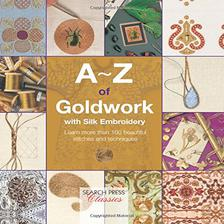

predicted:  Crafts, Hobbies & Home
orignial:  Crafts, Hobbies & Home
1782211705



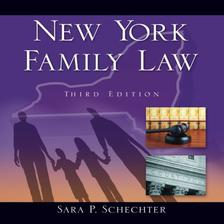

predicted:  Law
orignial:  Law
1111648441



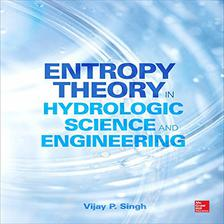

predicted:  Science & Math
orignial:  Science & Math
71835466



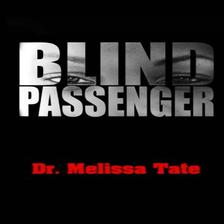

predicted:  Mystery, Thriller & Suspense
orignial:  Parenting & Relationships
692549935



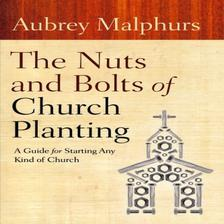

predicted:  Christian Books & Bibles
orignial:  Christian Books & Bibles
080107262X



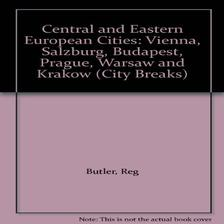

predicted:  Travel
orignial:  Travel
1872876617



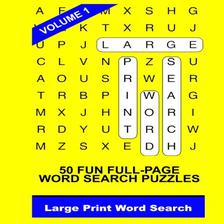

predicted:  Humor & Entertainment
orignial:  Humor & Entertainment
1502740524



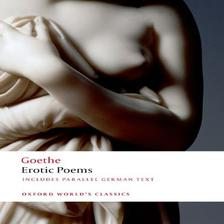

predicted:  Literature & Fiction
orignial:  Romance
199549729



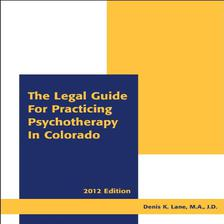

predicted:  Law
orignial:  Law
1932779752



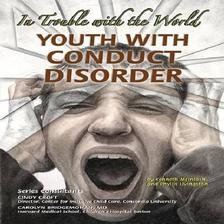

predicted:  Parenting & Relationships
orignial:  Teen & Young Adult
1422204405



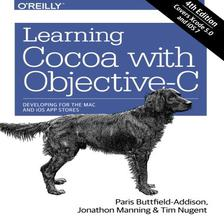

predicted:  Computers & Technology
orignial:  Computers & Technology
149190139X



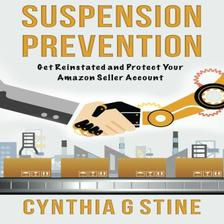

predicted:  Computers & Technology
orignial:  Computers & Technology
996721509



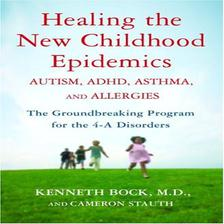

predicted:  Health, Fitness & Dieting
orignial:  Parenting & Relationships
B0027IQBG0



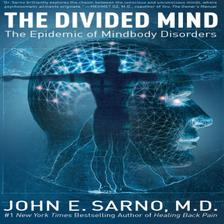

predicted:  Health, Fitness & Dieting
orignial:  Medical Books
61174300



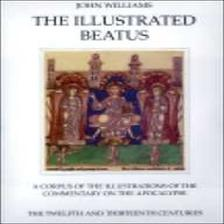

predicted:  Arts & Photography
orignial:  Arts & Photography
090520395X



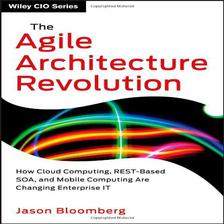

predicted:  Computers & Technology
orignial:  Computers & Technology
1118409779



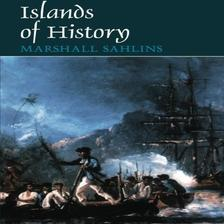

predicted:  History
orignial:  History
B00DT60YI0



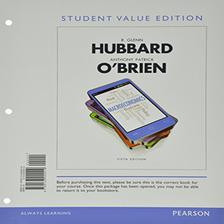

predicted:  Business & Money
orignial:  Business & Money
133827194



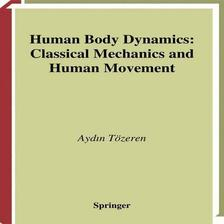

predicted:  Medical Books
orignial:  Medical Books
387988017



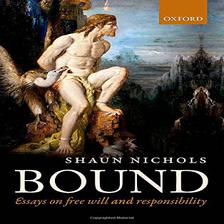

predicted:  Politics & Social Sciences
orignial:  Politics & Social Sciences
199291845



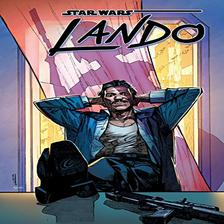

predicted:  Comics & Graphic Novels
orignial:  Comics & Graphic Novels
785193197



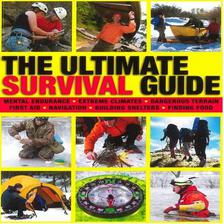

predicted:  Travel
orignial:  Sports & Outdoors
1782741429



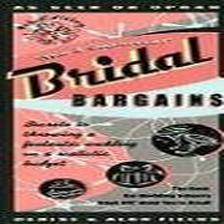

predicted:  Crafts, Hobbies & Home
orignial:  Crafts, Hobbies & Home
1889392294



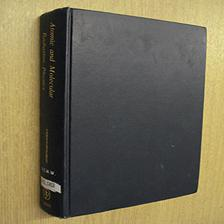

predicted:  Science & Math
orignial:  Science & Math
471156299



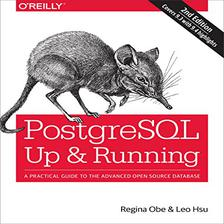

predicted:  Computers & Technology
orignial:  Computers & Technology
1449373194



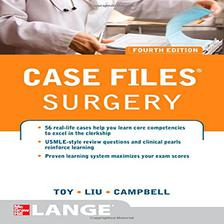

predicted:  Medical Books
orignial:  Test Preparation
71766995



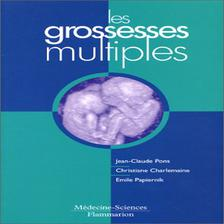

predicted:  Medical Books
orignial:  Parenting & Relationships
2257155653



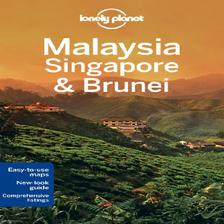

predicted:  Travel
orignial:  Travel
1741798477



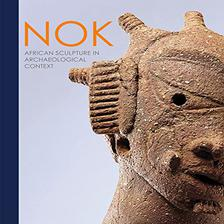

predicted:  Travel
orignial:  History
3937248463



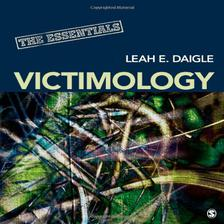

predicted:  Christian Books & Bibles
orignial:  Politics & Social Sciences
1452258392



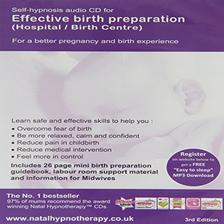

predicted:  Health, Fitness & Dieting
orignial:  Health, Fitness & Dieting
1905220502



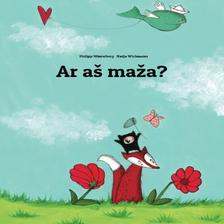

predicted:  Comics & Graphic Novels
orignial:  Children's Books
1493642146



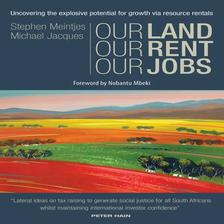

predicted:  Business & Money
orignial:  Law
856835048



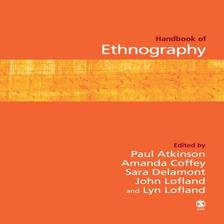

predicted:  Medical Books
orignial:  Politics & Social Sciences
1412946069



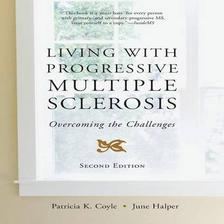

predicted:  Health, Fitness & Dieting
orignial:  Health, Fitness & Dieting
1932603476



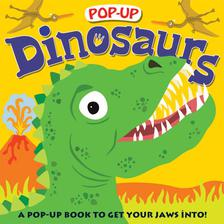

predicted:  Children's Books
orignial:  Children's Books
312515111



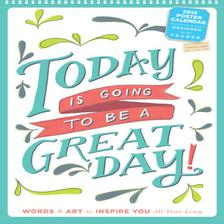

predicted:  Calendars
orignial:  Calendars
761179909



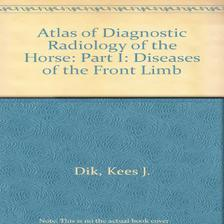

predicted:  Medical Books
orignial:  Medical Books
721627293



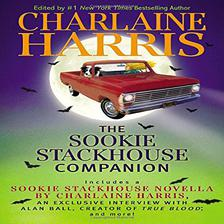

predicted:  Mystery, Thriller & Suspense
orignial:  Science Fiction & Fantasy
1937007898



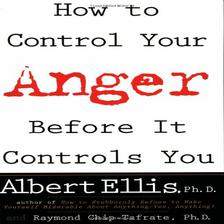

predicted:  Self-Help
orignial:  Self-Help
806520108



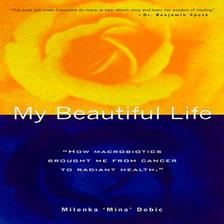

predicted:  Health, Fitness & Dieting
orignial:  Health, Fitness & Dieting
1899171134



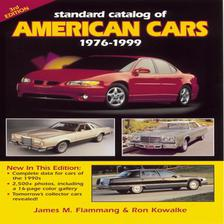

predicted:  Engineering & Transportation
orignial:  Engineering & Transportation
873417550



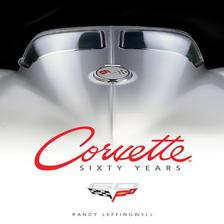

predicted:  Engineering & Transportation
orignial:  Engineering & Transportation
760342318



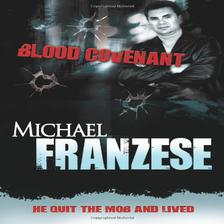

predicted:  Biographies & Memoirs
orignial:  Biographies & Memoirs
883688670



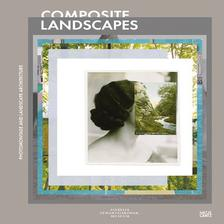

predicted:  Arts & Photography
orignial:  Arts & Photography
3775738193



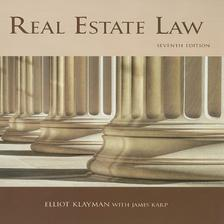

predicted:  Law
orignial:  Business & Money
1427782628



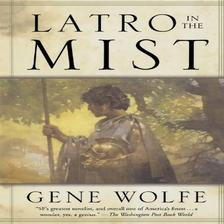

predicted:  Mystery, Thriller & Suspense
orignial:  Science Fiction & Fantasy
765302942



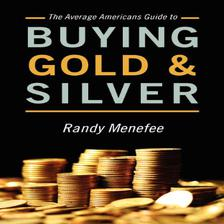

predicted:  Science & Math
orignial:  Reference
1478717009



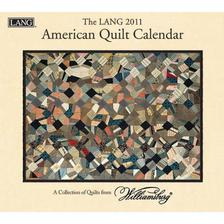

predicted:  Calendars
orignial:  Calendars
741234025



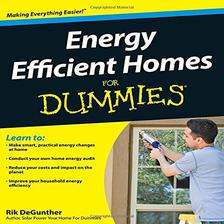

predicted:  Crafts, Hobbies & Home
orignial:  Crafts, Hobbies & Home
470376023



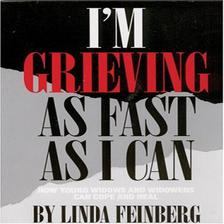

predicted:  Self-Help
orignial:  Self-Help
882820958



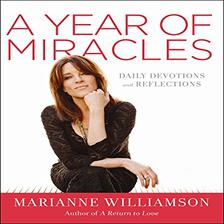

predicted:  Religion & Spirituality
orignial:  Christian Books & Bibles
62205501



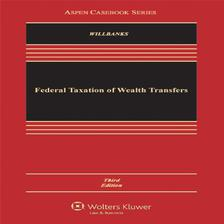

predicted:  Law
orignial:  Law
1454810149



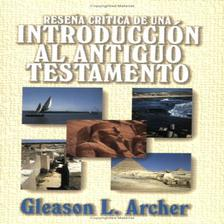

predicted:  Teen & Young Adult
orignial:  Christian Books & Bibles
825410339



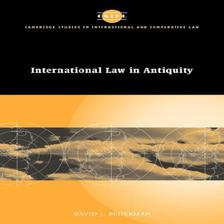

predicted:  Law
orignial:  Law
521033594



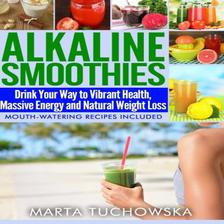

predicted:  Cookbooks, Food & Wine
orignial:  Cookbooks, Food & Wine
1515204456



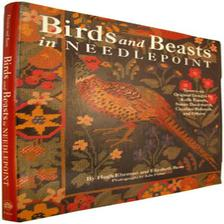

predicted:  Crafts, Hobbies & Home
orignial:  Crafts, Hobbies & Home
517574713



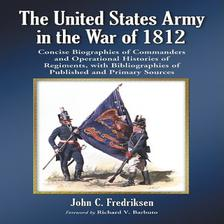

predicted:  History
orignial:  History
786441437



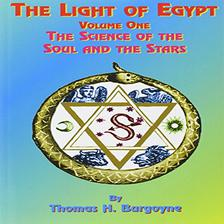

predicted:  Religion & Spirituality
orignial:  Self-Help
1585090514



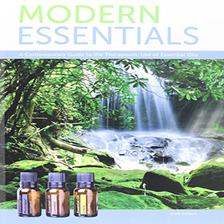

predicted:  Crafts, Hobbies & Home
orignial:  Health, Fitness & Dieting
1937702219



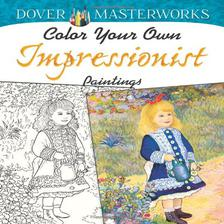

predicted:  Arts & Photography
orignial:  Crafts, Hobbies & Home
486780252



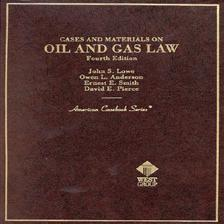

predicted:  Law
orignial:  Law
031426311X



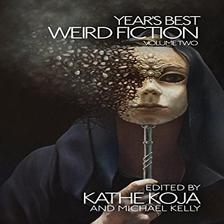

predicted:  Mystery, Thriller & Suspense
orignial:  Science Fiction & Fantasy
993895115



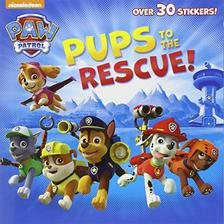

predicted:  Children's Books
orignial:  Children's Books
385384440



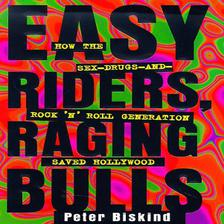

predicted:  Sports & Outdoors
orignial:  Biographies & Memoirs
684809966



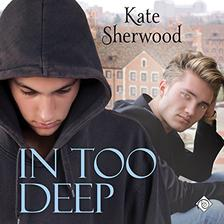

predicted:  Teen & Young Adult
orignial:  Romance
B0147CNPT4



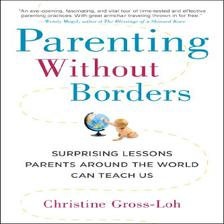

predicted:  Parenting & Relationships
orignial:  Politics & Social Sciences
1583335471



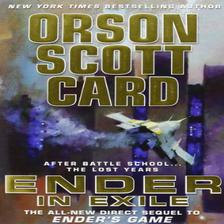

predicted:  Science Fiction & Fantasy
orignial:  Science Fiction & Fantasy
765344157



In [0]:
for i in range(100):
  get_prediction(df.sample().index[0])

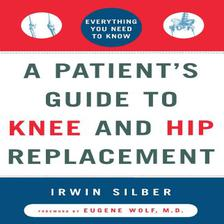

predicted:  Medical Books
orignial:  Health, Fitness & Dieting
684839202



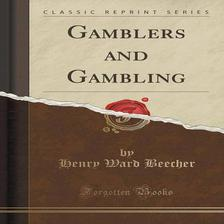

predicted:  Literature & Fiction
orignial:  Health, Fitness & Dieting
1330855574



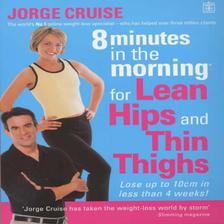

predicted:  Health, Fitness & Dieting
orignial:  Health, Fitness & Dieting
1405077387



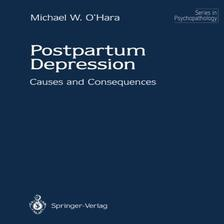

predicted:  Self-Help
orignial:  Health, Fitness & Dieting
1461384184



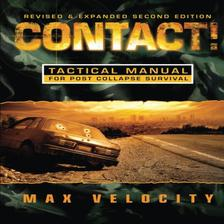

predicted:  Engineering & Transportation
orignial:  Health, Fitness & Dieting
1478106697



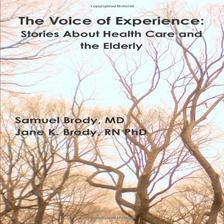

predicted:  Medical Books
orignial:  Health, Fitness & Dieting
578126303



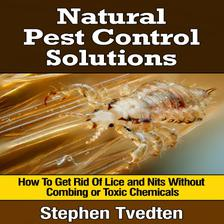

predicted:  Health, Fitness & Dieting
orignial:  Health, Fitness & Dieting
B00BF2AAPM



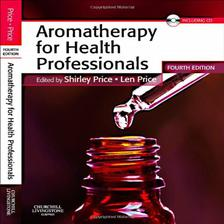

predicted:  Medical Books
orignial:  Health, Fitness & Dieting
702035645



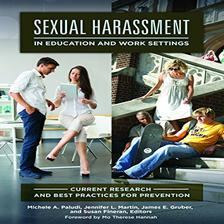

predicted:  Politics & Social Sciences
orignial:  Health, Fitness & Dieting
1440832935



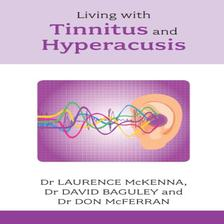

predicted:  Health, Fitness & Dieting
orignial:  Health, Fitness & Dieting
1847090834



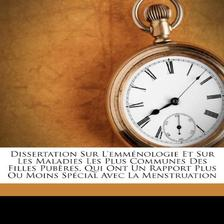

predicted:  Health, Fitness & Dieting
orignial:  Health, Fitness & Dieting
1246772361



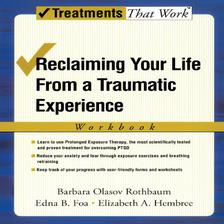

predicted:  Self-Help
orignial:  Health, Fitness & Dieting
195308484



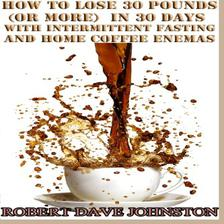

predicted:  Health, Fitness & Dieting
orignial:  Health, Fitness & Dieting
149100035X



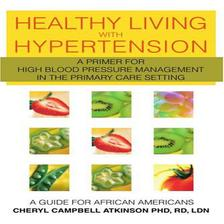

predicted:  Health, Fitness & Dieting
orignial:  Health, Fitness & Dieting
595333222



In [0]:
for i in range(14):
  get_prediction(df[df["cat_id"]==11].sample().index[0])

In [0]:
model.save_weights('concat.h5')